<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/SuperResolutionWithABPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attention-based Back Projection Network
https://arxiv.org/pdf/1910.04476.pdf

https://github.com/Holmes-Alan/ABPN

https://paperswithcode.com/task/image-super-resolution

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import shutil
import gdal
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import urllib.request
from torchsummary import summary
import numpy as np
from PIL import Image

In [ ]:
tilefile = "/content/training_tile_index.txt"
dataset_dir = "/content/validation/"
os.mkdir(dataset_dir)

In [ ]:
  tile = '1950'
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/"+tile+"_nlcd-2013.tif", dataset_dir+tile+"_nlcd-2013.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/"+tile+"_nlcd-2016.tif", dataset_dir+tile+"_nlcd-2016.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/naip-2013/"+tile+"_naip-2013.tif", dataset_dir+tile+"_naip-2013.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/naip-2017/"+tile+"_naip-2017.tif", dataset_dir+tile+"_naip-2017.tif")

  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/landsat-2017/"+tile+"_landsat-2017.tif", dataset_dir+tile+"_landsat-2017.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/landsat-2016/"+tile+"_landsat-2016.tif", dataset_dir+tile+"_landsat-2016.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/landsat-2013/"+tile+"_landsat-2013.tif", dataset_dir+tile+"_landsat-2013.tif")
  tile = '2002'
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/"+tile+"_nlcd-2013.tif", dataset_dir+tile+"_nlcd-2013.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/"+tile+"_nlcd-2016.tif", dataset_dir+tile+"_nlcd-2016.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/naip-2013/"+tile+"_naip-2013.tif", dataset_dir+tile+"_naip-2013.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/naip-2017/"+tile+"_naip-2017.tif", dataset_dir+tile+"_naip-2017.tif")

  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/landsat-2017/"+tile+"_landsat-2017.tif", dataset_dir+tile+"_landsat-2017.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/landsat-2016/"+tile+"_landsat-2016.tif", dataset_dir+tile+"_landsat-2016.tif")
  urllib.request.urlretrieve("https://dfc2021.blob.core.windows.net/competition-data/landsat-2013/"+tile+"_landsat-2013.tif", dataset_dir+tile+"_landsat-2013.tif")

('/content/validation/2002_landsat-2013.tif',
 <http.client.HTTPMessage at 0x7feadd191390>)

In [ ]:
#@title TileMaker Class
class TileMaker():

    def __init__(self, tile_index, root_dir, tilesize = 390, target_image_size = 3900):
        """
        args:
        str-tile_index:str list of naip tile indexes
        str-root_dir: root directory
        tilesize = size of sub tiles we wish to create
        image_size = size of naip images
        """
        with open(tile_index) as f:
            tiles = f.readlines()
            tiles = [t.replace("\n", "") for t in tiles]

        self.tiles = tiles
        self.root_dir = root_dir
        self.tilesize = tilesize
        self.image_size = target_image_size
        self.__repeats = int(np.ceil(target_image_size / tilesize))

    def __make_tiles(self, image):
        """
        Args:
        torch array - image (bands,w,h)
        splits an image into (n*n) tiles where n-repeats
        image must be (size*n,size*n)
        output:
        torch array - (ntiles, bands, w, h)
        """
        image = image.unsqueeze(0)
        splits = [self.tilesize for _ in range(self.__repeats)]
        tiles = image.split(splits, dim=-1)
        tiles = torch.cat(tiles, axis=0)
        tiles = tiles.split(splits, dim=-2)
        tiles = torch.cat(tiles)
        return tiles

    def __get_tensor(self, imagename, pad=True, unsqueeze=False):
        """args
        -imagename pathname for a tiff file
        returns a float32 torch tensor
        """

        image = torch.tensor(gdal.Open(imagename).ReadAsArray())

        isoddx = image.shape[-2]%2
        isoddy = image.shape[-1]%2


        if pad:
            padx = int((self.image_size - image.shape[-2])/2)
            pady = int((self.image_size - image.shape[-1])/2)

            image = F.pad(image, [pady, pady + isoddy, padx + isoddx, padx])

        
        if unsqueeze:
            image = image.unsqueeze(0)
        return image


    def write_naip_tiles_singleband(self, tiledir, return_tiles_and_bands=False, saveformat = "tif"):
        """
        writes tiles to target directory
        Args
        str - tiledir : target directory
        saveformat - see PIL.Image.save()
        """
        

        if not (os.path.isdir(tiledir)):
            os.mkdir(tiledir)

        supertiles = self.tiles
        # (naip images in the datasets are also called tiles, we are making tiles out of these tiles)
        for supertile in supertiles:

            img_name2013 = os.path.join(self.root_dir, supertile + "_naip-2013.tif")
            img_name2017 = os.path.join(self.root_dir, supertile + "_naip-2017.tif")

            image2013 = self.__get_tensor(img_name2013)
            image2017 = self.__get_tensor(img_name2017)


            batches2013 = self.__make_tiles(image2013)
            batches2017 = self.__make_tiles(image2017)

            # (25,nbands,780,780)
            ntiles, bands, _, _ = batches2013.shape

            for tile in range(ntiles):
                for band in range(bands):
                    # tilename format /content/tiles/2002_99_0_naip2013.pt
                    # use tilename.split("_") = ['/content/tiles/2002', '99', '0', 'naip2013.pt'] to reacquire tile and band
                    tilename1 = os.path.join(tiledir, supertile + "_" + str(tile) + "_" + str(band) + "_naip2013."+saveformat)
                    tilename2 = os.path.join(tiledir, supertile + "_" + str(tile) + "_" + str(band) + "_naip2017."+saveformat)
                    image1 = Image.fromarray(batches2013[tile, band, :, :].numpy())
                    image2 = Image.fromarray(batches2017[tile, band, :, :].numpy())

                    if saveformat == 'tif':
                        saveformat = 'tiff'
                        

                    image1.save(tilename1, format=saveformat)
                    image2.save(tilename2, fotmat=saveformat)
                    

            if return_tiles_and_bands:
                return ntiles, bands

    def write_naip_tiles_rgb(self, tiledir, return_tiles_and_bands=False, saveformat = "tif"):
        """
        writes tiles to target directory
        Args
        str - tiledir : target directory
        saveformat - see PIL.Image.save()
        """
        

        if not (os.path.isdir(tiledir)):
            os.mkdir(tiledir)

        supertiles = self.tiles
        # (naip images in the datasets are also called tiles, we are making tiles out of these tiles)
        for supertile in supertiles:

            img_name2013 = os.path.join(self.root_dir, supertile + "_naip-2013.tif")
            img_name2017 = os.path.join(self.root_dir, supertile + "_naip-2017.tif")

            image2013 = self.__get_tensor(img_name2013)
            image2017 = self.__get_tensor(img_name2017)


            batches2013 = self.__make_tiles(image2013)
            batches2017 = self.__make_tiles(image2017)

            # (25,nbands,780,780)
            ntiles, bands, _, _ = batches2013.shape

            for tile in range(ntiles):

                    # tilename format /content/tiles/2002_99_0_naip2013.pt
                    # use tilename.split("_") = ['/content/tiles/2002', '99', '0', 'naip2013.pt'] to reacquire tile and band
                    tilename1 = os.path.join(tiledir, supertile + "_" + str(tile) + "_naip2013."+saveformat)
                    tilename2 = os.path.join(tiledir, supertile + "_" + str(tile) + "_naip2017."+saveformat)

                    image1 = Image.fromarray(batches2013[tile, 0:3, :, :].numpy().transpose((1,2,0)))
                    image2 = Image.fromarray(batches2017[tile, 0:3, :, :].numpy().transpose((1,2,0)))

                    if saveformat == 'tif':
                        saveformat = 'tiff'
                        

                    image1.save(tilename1, format=saveformat)
                    image2.save(tilename2, fotmat=saveformat)
                    

            if return_tiles_and_bands:
                return ntiles, bands

In [ ]:
tilemaker = TileMaker("/content/training_tile_index.txt","/content/validation")
tilemaker.write_naip_tiles_singleband("/content/train")

In [ ]:
#@title Dataset Class
class NAIPSuperResDS(Dataset):
    """
    feature: low resolution (1,13,13)
    target: high resolution tiles (1,390,390)
    """

    def __init__(self, dataset_dir, image_size=390, transform=False):
        """
        Args:
            dataset_dir(string): directory with images
            transform : a torch transformation or false
        """
        self.dataset_dir = dataset_dir
        self.image_size = image_size
        self.__dir_list = os.listdir(dataset_dir)
        self.transform = transform

    def __len__(self):
        return len(self.__dir_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filename = self.__dir_list[idx]

        filename = os.path.join(self.dataset_dir, filename)

        image = torch.tensor(gdal.Open(filename).ReadAsArray().astype(np.float32)) / 255
        image = image.unsqueeze(0)
        # (1,390,390)

        if self.transform:
            image = self.transform(image)

        pool = nn.MaxPool2d(30, stride=30)
        low_res = pool(image)

        sample = {'low_res': low_res, 'high_res': image}

        return sample

In [ ]:
sr_dataset = NAIPSuperResDS("/content/train")
training_data_loader = DataLoader(sr_dataset,batch_size = 8, shuffle = True,num_workers=8)
train_iter = iter(training_data_loader)

In [ ]:
#@title ABPN
class ABPN_v3(nn.Module):
    """
    Both scale_factor and stride+kernel_size must be adjusted. stride=rs_factor/n, kernel_size = stride+2
    where n is the first upscaling factor
    """
    def __init__(self, input_dim, dim):
        super(ABPN_v3, self).__init__()
        kernel_size = 17
        pad = 1
        stride = 15

        self.feat1 = ConvBlock(input_dim, 2 * dim, 3, 1, 1)
        self.SA0 = Space_attention(2 * dim, 2 * dim, 1, 1, 0, 1)
        self.feat2 = ConvBlock(2 * dim, dim, 3, 1, 1)
        # BP 1
        self.up1 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.down1 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA1 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 2
        self.up2 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.down2 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA2 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 3
        self.weight_up1 = ConvBlock(dim, dim, 1, 1, 0)
        self.up3 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down1 = ConvBlock(dim, dim, 1, 1, 0)
        self.down3 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA3 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 4
        self.weight_up2 = ConvBlock(dim, dim, 1, 1, 0)
        self.up4 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down2 = ConvBlock(dim, dim, 1, 1, 0)
        self.down4 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA4 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP5
        self.weight_up3 = ConvBlock(dim, dim, 1, 1, 0)
        self.up5 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down3 = ConvBlock(dim, dim, 1, 1, 0)
        self.down5 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA5 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP6
        self.weight_up4 = ConvBlock(dim, dim, 1, 1, 0)
        self.up6 = UpBlock(dim, dim, kernel_size, stride, pad)
        # reconstruction
        self.SR_conv1 = ConvBlock(6 * dim, dim, 1, 1, 0)
        self.SR_conv2 = ConvBlock(dim, dim, 3, 1, 1)
        self.LR_conv1 = ConvBlock(5 * dim, dim, 1, 1, 0)
        self.LR_conv2 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.SR_conv3 = nn.Conv2d(dim, input_dim, 3, 1, 1)

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif classname.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # feature extraction
        bic_x = F.interpolate(x, scale_factor=2, mode='bicubic')
        feat_x = self.feat1(bic_x)
        SA0 = self.SA0(feat_x)
        feat_x = self.feat2(SA0)
        # BP 1
        up1 = self.up1(feat_x)
        down1 = self.down1(up1)
        down1 = self.SA1(feat_x, down1)
        # BP 2
        up2 = self.up2(down1)
        down2 = self.down2(up2)
        down2 = self.SA2(down1, down2)
        # BP 3
        up3 = self.up3(down2) + self.weight_up1(up1)
        down3 = self.down3(up3)
        down3 = self.SA3(self.weight_down1(down1), down3)
        # BP 4
        up4 = self.up4(down3) + self.weight_up2(up2)
        down4 = self.down4(up4)
        down4 = self.SA4(self.weight_down2(down2), down4)
        # BP 5
        up5 = self.up5(down4) + self.weight_up3(up3)
        down5 = self.down5(up5)
        down5 = self.SA5(self.weight_down3(down3), down5)
        # BP 6
        up6 = self.up6(down5) + self.weight_up4(up4)
        # reconstruction
        HR_feat = torch.cat((up1, up2, up3, up4, up5, up6), 1)
        LR_feat = torch.cat((down1, down2, down3, down4, down5), 1)
        HR_feat = self.SR_conv1(HR_feat)
        HR_feat = self.SR_conv2(HR_feat)
        LR_feat = self.LR_conv1(LR_feat)
        LR_feat = self.LR_conv2(LR_feat)
        SR_res = self.SR_conv3(HR_feat + LR_feat)
        bic_x = F.interpolate(bic_x, scale_factor=15, mode='bicubic')
        
        SR = bic_x + SR_res

        
        return SR


class ABPN_v5(nn.Module):
    def __init__(self, input_dim, dim):
        super(ABPN_v5, self).__init__()
        kernel_size = 6
        pad = 1
        stride = 4

        self.feat1 = ConvBlock(input_dim, 2 * dim, 3, 1, 1)
        self.SA0 = Space_attention(2 * dim, 2 * dim, 1, 1, 0, 1)
        self.feat2 = ConvBlock(2 * dim, dim, 3, 1, 1)
        # BP 1
        self.up1 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.down1 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA1 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 2
        self.up2 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.down2 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA2 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 3
        self.weight_up1 = ConvBlock(dim, dim, 1, 1, 0)
        self.up3 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down1 = ConvBlock(dim, dim, 1, 1, 0)
        self.down3 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA3 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP 4
        self.weight_up2 = ConvBlock(dim, dim, 1, 1, 0)
        self.up4 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down2 = ConvBlock(dim, dim, 1, 1, 0)
        self.down4 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA4 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP5
        self.weight_up3 = ConvBlock(dim, dim, 1, 1, 0)
        self.up5 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down3 = ConvBlock(dim, dim, 1, 1, 0)
        self.down5 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA5 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP6
        self.weight_up4 = ConvBlock(dim, dim, 1, 1, 0)
        self.up6 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down4 = ConvBlock(dim, dim, 1, 1, 0)
        self.down6 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA6 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP7
        self.weight_up5 = ConvBlock(dim, dim, 1, 1, 0)
        self.up7 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down5 = ConvBlock(dim, dim, 1, 1, 0)
        self.down7 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA7 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP8
        self.weight_up6 = ConvBlock(dim, dim, 1, 1, 0)
        self.up8 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down6 = ConvBlock(dim, dim, 1, 1, 0)
        self.down8 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA8 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP9
        self.weight_up7 = ConvBlock(dim, dim, 1, 1, 0)
        self.up9 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down7 = ConvBlock(dim, dim, 1, 1, 0)
        self.down9 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA9 = Time_attention(dim, dim, 1, 1, 0, 1)
        # BP10
        self.weight_up8 = ConvBlock(dim, dim, 1, 1, 0)
        self.up10 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.weight_down8 = ConvBlock(dim, dim, 1, 1, 0)
        self.down10 = DownBlock(dim, dim, kernel_size, stride, pad)
        self.SA10 = Time_attention(dim, dim, 1, 1, 0, 1)
        # reconstruction
        self.SR_conv1 = ConvBlock(10 * dim, dim, 1, 1, 0)
        self.SR_conv2 = ConvBlock(dim, dim, 3, 1, 1)
        self.LR_conv1 = ConvBlock(9 * dim, dim, 1, 1, 0)
        self.LR_conv2 = UpBlock(dim, dim, kernel_size, stride, pad)
        self.SR_conv3 = nn.Conv2d(dim, input_dim, 3, 1, 1)
        # BP final
        self.final_feat1 = ConvBlock(input_dim, 2 * dim, 3, 1, 1)
        self.final_SA0 = Space_attention(2 * dim, 2 * dim, 1, 1, 0, 1)
        self.final_feat2 = nn.Conv2d(2 * dim, input_dim, 3, 1, 1)

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif classname.find('ConvTranspose2d') != -1:
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # feature extraction
        bic_x = F.interpolate(x, scale_factor=4, mode='bicubic')
        feat_x = self.feat1(x)
        SA0 = self.SA0(feat_x)
        feat_x = self.feat2(SA0)
        # BP 1
        up1 = self.up1(feat_x)
        down1 = self.down1(up1)
        down1 = self.SA1(feat_x, down1)
        # BP 2
        up2 = self.up2(down1)
        down2 = self.down2(up2)
        down2 = self.SA2(down1, down2)
        # BP 3
        up3 = self.up3(down2) + self.weight_up1(up1)
        down3 = self.down3(up3)
        down3 = self.SA3(self.weight_down1(down1), down3)
        # BP 4
        up4 = self.up4(down3) + self.weight_up2(up2)
        down4 = self.down4(up4)
        down4 = self.SA4(self.weight_down2(down2), down4)
        # BP 5
        up5 = self.up5(down4) + self.weight_up3(up3)
        down5 = self.down5(up5)
        down5 = self.SA5(self.weight_down3(down3), down5)
        # BP 6
        up6 = self.up6(down5) + self.weight_up4(up4)
        down6 = self.down6(up6)
        down6 = self.SA6(self.weight_down4(down4), down6)
        # BP 7
        up7 = self.up7(down6) + self.weight_up5(up5)
        down7 = self.down7(up7)
        down7 = self.SA7(self.weight_down5(down5), down7)
        # BP 8
        up8 = self.up8(down7) + self.weight_up6(up6)
        down8 = self.down8(up8)
        down8 = self.SA8(self.weight_down6(down6), down8)
        # BP 9
        up9 = self.up9(down8) + self.weight_up7(up7)
        down9 = self.down9(up9)
        down9 = self.SA9(self.weight_down7(down7), down9)
        # BP 10
        up10 = self.up10(down9) + self.weight_up8(up8)
        # reconstruction
        HR_feat = torch.cat((up1, up2, up3, up4, up5, up6, up7, up8, up9, up10), 1)
        LR_feat = torch.cat((down1, down2, down3, down4, down5, down6, down7, down8, down9), 1)
        HR_feat = self.SR_conv1(HR_feat)
        HR_feat = self.SR_conv2(HR_feat)
        LR_feat = self.LR_conv1(LR_feat)
        LR_feat = self.LR_conv2(LR_feat)
        SR_res = self.SR_conv3(HR_feat + LR_feat)

        SR = bic_x + SR_res

        LR_res = x - F.interpolate(SR, scale_factor=0.25, mode='bicubic')
        LR_res = self.final_feat1(LR_res)
        LR_SA = self.final_SA0(LR_res)
        LR_res = self.final_feat2(LR_SA)

        SR_res = F.interpolate(LR_res, scale_factor=4, mode='bicubic')


        SR = SR + SR_res

        return SR



############################################################################################
# Base models
############################################################################################

class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, bias=True):
        super(ConvBlock, self).__init__()

        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.act = torch.nn.PReLU()

    def forward(self, x):
        out = self.conv(x)

        return self.act(out)


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, bias=True):
        super(DeconvBlock, self).__init__()

        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding, bias=bias)

        self.act = torch.nn.PReLU()

    def forward(self, x):
        out = self.deconv(x)

        return self.act(out)


class UpBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding):
        super(UpBlock, self).__init__()

        self.conv1 = DeconvBlock(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.conv2 = ConvBlock(output_size, output_size, kernel_size, stride, padding, bias=True)
        self.conv3 = DeconvBlock(output_size, output_size, kernel_size, stride, padding, bias=True)
        self.local_weight1 = ConvBlock(input_size, output_size, kernel_size=1, stride=1, padding=0, bias=True)
        self.local_weight2 = ConvBlock(output_size, output_size, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        hr = self.conv1(x)
        lr = self.conv2(hr)
        residue = self.local_weight1(x) - lr
        h_residue = self.conv3(residue)
        hr_weight = self.local_weight2(hr)
        return hr_weight + h_residue


class DownBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding):
        super(DownBlock, self).__init__()

        self.conv1 = ConvBlock(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.conv2 = DeconvBlock(output_size, output_size, kernel_size, stride, padding, bias=True)
        self.conv3 = ConvBlock(output_size, output_size, kernel_size, stride, padding, bias=True)
        self.local_weight1 = ConvBlock(input_size, output_size, kernel_size=1, stride=1, padding=0, bias=True)
        self.local_weight2 = ConvBlock(output_size, output_size, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        lr = self.conv1(x)
        hr = self.conv2(lr)
        residue = self.local_weight1(x) - hr
        l_residue = self.conv3(residue)
        lr_weight = self.local_weight2(lr)
        return lr_weight + l_residue


class ResnetBlock(torch.nn.Module):
    def __init__(self, num_filter, kernel_size=3, stride=1, padding=1, bias=True):
        super(ResnetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(num_filter, num_filter, kernel_size, stride, padding, bias=bias)
        self.conv2 = torch.nn.Conv2d(num_filter, num_filter, kernel_size, stride, padding, bias=bias)

        self.act1 = torch.nn.PReLU()
        self.act2 = torch.nn.PReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = out + x
        out = self.act2(out)

        return out


class Space_attention(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Space_attention, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale
        # downscale = scale + 4

        self.K = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.Q = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.V = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=self.scale + 2, stride=self.scale, padding=1)
        #self.bn = nn.BatchNorm2d(output_size)
        if kernel_size == 1:
            self.local_weight = torch.nn.Conv2d(output_size, input_size, kernel_size, stride, padding,
                                                bias=True)
        else:
            self.local_weight = torch.nn.ConvTranspose2d(output_size, input_size, kernel_size, stride, padding,
                                                         bias=True)


    def forward(self, x):
        batch_size = x.size(0)
        K = self.K(x)
        Q = self.Q(x)
        # Q = F.interpolate(Q, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            Q = self.pool(Q)
        else:
            Q = Q
        V = self.V(x)
        # V = F.interpolate(V, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            V = self.pool(V)
        else:
            V = V
        V_reshape = V.view(batch_size, self.output_size, -1)
        V_reshape = V_reshape.permute(0, 2, 1)
        # if self.type == 'softmax':
        Q_reshape = Q.view(batch_size, self.output_size, -1)

        K_reshape = K.view(batch_size, self.output_size, -1)
        K_reshape = K_reshape.permute(0, 2, 1)

        KQ = torch.matmul(K_reshape, Q_reshape)
        attention = F.softmax(KQ, dim=-1)

        vector = torch.matmul(attention, V_reshape)
        vector_reshape = vector.permute(0, 2, 1).contiguous()
        O = vector_reshape.view(batch_size, self.output_size, x.size(2) // self.stride, x.size(3) // self.stride)
        W = self.local_weight(O)
        output = x + W
        #output = self.bn(output)
        return output

class Space_attention_v2(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Space_attention_v2, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale
        # downscale = scale + 4

        self.K = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.Q = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.V = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=self.scale + 2, stride=self.scale, padding=1)
        #self.bn = nn.BatchNorm2d(output_size)
        if kernel_size == 1:
            self.local_weight = torch.nn.Conv2d(output_size, input_size, kernel_size, stride, padding, bias=True)
        else:
            self.local_weight = torch.nn.ConvTranspose2d(output_size, input_size, kernel_size, stride, padding, bias=True)


    def forward(self, x):
        batch_size = x.size(0)
        K = self.K(x)
        Q = self.Q(x)
        # Q = F.interpolate(Q, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            Q = self.pool(Q)
        else:
            Q = Q
        V = self.V(x)
        # V = F.interpolate(V, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            V = self.pool(V)
        else:
            V = V
        V_reshape = V.view(batch_size, self.output_size, -1)
        V_reshape = V_reshape.permute(0, 2, 1)
        # if self.type == 'softmax':
        Q_reshape = Q.view(batch_size, self.output_size, -1)

        K_reshape = K.view(batch_size, self.output_size, -1)
        K_reshape = K_reshape.permute(0, 2, 1)

        QV = torch.matmul(Q_reshape, V_reshape)
        attention = F.softmax(QV, dim=-1)

        vector = torch.matmul(K_reshape, attention)
        vector_reshape = vector.permute(0, 2, 1).contiguous()
        O = vector_reshape.view(batch_size, self.output_size, x.size(2) // self.stride, x.size(3) // self.stride)
        W = self.local_weight(O)
        output = x + W
        #output = self.bn(output)
        return output

class Time_attention(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Time_attention, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale
        # downscale = scale + 4

        self.K = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.Q = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.V = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=self.scale + 2, stride=self.scale, padding=1)
        #self.bn = nn.BatchNorm2d(output_size)
        if kernel_size == 1:
            self.local_weight = torch.nn.Conv2d(output_size, input_size, kernel_size, stride, padding,
                                                bias=True)
        else:
            self.local_weight = torch.nn.ConvTranspose2d(output_size, input_size, kernel_size, stride, padding,
                                                         bias=True)


    def forward(self, x, y):
        batch_size = x.size(0)
        K = self.K(x)
        Q = self.Q(x)
        # Q = F.interpolate(Q, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            Q = self.pool(Q)
        else:
            Q = Q
        V = self.V(y)
        # V = F.interpolate(V, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            V = self.pool(V)
        else:
            V = V
        #attention = x
        V_reshape = V.view(batch_size, self.output_size, -1)
        V_reshape = V_reshape.permute(0, 2, 1)

        # if self.type == 'softmax':
        Q_reshape = Q.view(batch_size, self.output_size, -1)

        K_reshape = K.view(batch_size, self.output_size, -1)
        K_reshape = K_reshape.permute(0, 2, 1)

        KQ = torch.matmul(K_reshape, Q_reshape)
        attention = F.softmax(KQ, dim=-1)
        vector = torch.matmul(attention, V_reshape)
        vector_reshape = vector.permute(0, 2, 1).contiguous()
        O = vector_reshape.view(batch_size, self.output_size, x.size(2) // self.stride, x.size(3) // self.stride)
        W = self.local_weight(O)
        output = y + W
        #output = self.bn(output)
        return output

class Time_attention_v2(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Time_attention_v2, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale
        # downscale = scale + 4

        self.K = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.Q = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.V = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=self.scale + 2, stride=self.scale, padding=1)
        #self.bn = nn.BatchNorm2d(output_size)
        if kernel_size == 1:
            self.local_weight = torch.nn.Conv2d(output_size, input_size, kernel_size, stride, padding, bias=True)
        else:
            self.local_weight = torch.nn.ConvTranspose2d(output_size, input_size, kernel_size, stride, padding, bias=True)


    def forward(self, x, y):
        batch_size = x.size(0)
        K = self.K(x)
        Q = self.Q(x)
        # Q = F.interpolate(Q, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            Q = self.pool(Q)
        else:
            Q = Q
        V = self.V(y)
        # V = F.interpolate(V, scale_factor=1 / self.scale, mode='bicubic')
        if self.stride > 1:
            V = self.pool(V)
        else:
            V = V
        #attention = x
        V_reshape = V.view(batch_size, self.output_size, -1)
        V_reshape = V_reshape.permute(0, 2, 1)

        # if self.type == 'softmax':
        Q_reshape = Q.view(batch_size, self.output_size, -1)

        K_reshape = K.view(batch_size, self.output_size, -1)
        K_reshape = K_reshape.permute(0, 2, 1)

        QV = torch.matmul(Q_reshape, V_reshape)
        attention = F.softmax(QV, dim=-1)
        vector = torch.matmul(K_reshape, attention)
        vector_reshape = vector.permute(0, 2, 1).contiguous()
        O = vector_reshape.view(batch_size, self.output_size, x.size(2) // self.stride, x.size(3) // self.stride)
        W = self.local_weight(O)
        output = y + W
        #output = self.bn(output)
        return output

class Space_Time_Attention(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Space_Time_Attention, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale

        # First Space Attention
        self.SA_x1 = Space_attention(input_size, output_size, kernel_size, stride, padding, scale)
        self.SA_y1 = Space_attention(input_size, output_size, kernel_size, stride, padding, scale)
        self.resblock_x1 = ResnetBlock(output_size, kernel_size=3, stride=1, padding=1, bias=True)
        self.resblock_y1 = ResnetBlock(output_size, kernel_size=3, stride=1, padding=1, bias=True)
        # First Time Attention
        self.TA_y1 = Time_attention(input_size, output_size, kernel_size, stride, padding, scale)

    def forward(self, x, y):
        # First Space attention
        x1 = self.SA_x1(x)
        y1 = self.SA_y1(y)
        x1 = self.resblock_x1(x1)
        # First Time attention
        y1 = self.TA_y1(x1, y1)
        y1 = self.resblock_y1(y1)

        return x1, y1


class Space_Time_Attention_v2(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, padding, scale):
        super(Space_Time_Attention_v2, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = scale

        # First Space Attention
        self.SA_x1 = Space_attention_v2(input_size, output_size, kernel_size, stride, padding, scale)
        self.SA_y1 = Space_attention_v2(input_size, output_size, kernel_size, stride, padding, scale)
        self.resblock_x1 = ResnetBlock(output_size, kernel_size=3, stride=1, padding=1, bias=True)
        self.resblock_y1 = ResnetBlock(output_size, kernel_size=3, stride=1, padding=1, bias=True)
        # First Time Attention
        self.TA_y1 = Time_attention_v2(input_size, output_size, kernel_size, stride, padding, scale)

    def forward(self, x, y):
        # First Space attention
        x1 = self.SA_x1(x)
        y1 = self.SA_y1(y)
        x1 = self.resblock_x1(x1)
        # First Time attention
        y1 = self.TA_y1(x1, y1)
        y1 = self.resblock_y1(y1)

        return x1, y1

In [ ]:
def train(epoch):
    epoch_loss = 0
    model.train()
    for iteration, batch in enumerate(training_data_loader, 1):

        input, target = Variable(batch["low_res"]), Variable(batch["high_res"])
        if cuda:
            input = input.cuda(gpus_list[0])
            target = target.cuda(gpus_list[0])


        optimizer.zero_grad()
        t0 = time.time()

        prediction = model(input)

        # Reconstruction loss
        loss = L1_criterion(prediction, target)

        t1 = time.time()
        epoch_loss += loss.data
        loss.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print("===> Epoch[{}]({}/{}): Loss_recon: {:.4f} || Timer: {:.4f} sec.".format(epoch, iteration,
                                                                                    len(training_data_loader), loss.data,
                                                                                    (t1 - t0)))

    #print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)


def checkpoint(epoch, model_out_path = "/content/checkpoint"):
    #model_out_path = opt.save_folder + opt.model_type + "_epoch_{}.pth".format(epoch)
    torch.save(model.state_dict(), model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))
  

In [ ]:
cuda = True
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from math import log, pow
import socket
import time
from torch.distributions.normal import Normal

In [ ]:
gpus_list = range(0,1)
hostname = str(socket.gethostname())
cudnn.benchmark = True
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()
torch.cuda.current_device()
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ABPN_v3(input_dim=1, dim=13)
model = torch.nn.DataParallel(model)
model = model.to(device)

In [ ]:
summary(model,(1,10,10))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 26, 20, 20]             260
             PReLU-2           [-1, 26, 20, 20]               1
         ConvBlock-3           [-1, 26, 20, 20]               0
            Conv2d-4           [-1, 26, 20, 20]             702
            Conv2d-5           [-1, 26, 20, 20]             702
            Conv2d-6           [-1, 26, 20, 20]             702
            Conv2d-7           [-1, 26, 20, 20]             702
   Space_attention-8           [-1, 26, 20, 20]               0
            Conv2d-9           [-1, 13, 20, 20]           3,055
            PReLU-10           [-1, 13, 20, 20]               1
        ConvBlock-11           [-1, 13, 20, 20]               0
  ConvTranspose2d-12         [-1, 13, 300, 300]          48,854
            PReLU-13         [-1, 13, 300, 300]               1
      DeconvBlock-14         [-1, 13, 3

In [ ]:
L1_criterion = nn.L1Loss()
L2_criterion = nn.MSELoss(size_average=False)
if cuda:
    model = model.cuda(gpus_list[0])
    #netF = define_F(opt).cuda(gpus_list[0])
    L1_criterion = L1_criterion.cuda(gpus_list[0])
    L2_criterion = L2_criterion.cuda(gpus_list[0])

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
nepochs=20

In [ ]:
for epoch in range(0,nepochs+1):
    train(epoch)

    # learning rate is decayed by a factor of 10 every half of total epochs
    if (epoch + 1) % 2:
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 3
        print('Learning rate decay: lr={}'.format(optimizer.param_groups[0]['lr']))

    if epoch % (5) == 0:
        checkpoint(epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


===> Epoch[0](100/200): Loss_recon: 0.0974 || Timer: 0.0159 sec.
===> Epoch[0](200/200): Loss_recon: 0.0915 || Timer: 0.0176 sec.
Learning rate decay: lr=3.3333333333333335e-05
Checkpoint saved to /content/checkpoint
===> Epoch[1](100/200): Loss_recon: 0.0916 || Timer: 0.0211 sec.
===> Epoch[1](200/200): Loss_recon: 0.0875 || Timer: 0.0158 sec.
===> Epoch[2](100/200): Loss_recon: 0.1102 || Timer: 0.0159 sec.
===> Epoch[2](200/200): Loss_recon: 0.0960 || Timer: 0.0157 sec.
Learning rate decay: lr=1.1111111111111112e-05
===> Epoch[3](100/200): Loss_recon: 0.0923 || Timer: 0.0158 sec.
===> Epoch[3](200/200): Loss_recon: 0.0908 || Timer: 0.0160 sec.
===> Epoch[4](100/200): Loss_recon: 0.0822 || Timer: 0.0163 sec.
===> Epoch[4](200/200): Loss_recon: 0.1179 || Timer: 0.0158 sec.
Learning rate decay: lr=3.7037037037037037e-06
===> Epoch[5](100/200): Loss_recon: 0.1106 || Timer: 0.0156 sec.
===> Epoch[5](200/200): Loss_recon: 0.0868 || Timer: 0.0158 sec.
Checkpoint saved to /content/checkpoint

In [ ]:
test_batch = train_iter.next()
high_res = model.forward(test_batch["low_res"]).cpu().detach().numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
import matplotlib.pyplot as plt


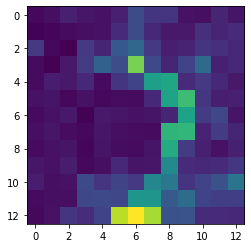

In [ ]:
plt.imshow(test_batch["low_res"][0,0,:,:])

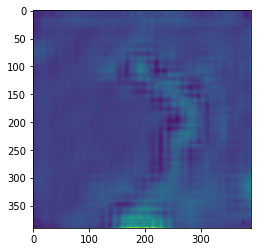

In [ ]:
plt.imshow(high_res[0,0,:,:])

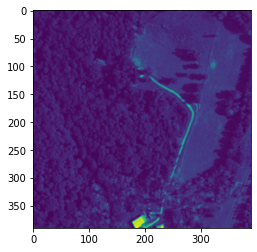

In [ ]:
plt.imshow(test_batch["high_res"][0,0,:,:])

Possible explanation of poor performance:

Features are sub-pixel size with respect to the low_res image. Literally impossible to resolve what we are trying to look at. I believe this is an important lesson here.